In [11]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile

import sklearn
from sklearn import cross_validation
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression

from skimage import io, transform, color

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import os
import re

## Подготовка трейн данных

In [2]:
MODEL_DIR = 'imagenet'

TEST_PATH = "./finetuning-test/images"
TRAIN_PATH = "./finetuning-train/images"
LABELS_PATH = "./finetuning-train/gt.csv"

In [3]:
data = pd.read_csv(LABELS_PATH)
labels = data.drop(['filename'], axis=1)

In [4]:
train_images = sorted([os.path.join(TRAIN_PATH, f) for f in os.listdir(TRAIN_PATH)])
train_images[:3]

['./finetuning-train/images/0000.png',
 './finetuning-train/images/0001.png',
 './finetuning-train/images/0002.png']

In [5]:
def create_graph():
    _graph = 'classify_image_graph_def.pb'
    with gfile.FastGFile(os.path.join(MODEL_DIR, _graph), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def,
                                name='')

In [9]:
def extract_features(list_images):
    nb_features = 2048
    features = np.empty((len(list_images), nb_features))
    labels = []

    create_graph()

    with tf.Session() as sess:
        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')
        
        for ind, image in enumerate(list_images):
            if (ind % 100 == 0):
                print('Processing {0:s}...'.format(image.split('/')[-1]))
                #io.imshow(io.imread(os.path.join(image)))
                #plt.show()
            
            if not gfile.Exists(image):
                tf.logging.fatal('File does not exist {0:s}'.format(image))

            image_data = gfile.FastGFile(image, 'rb').read()
            predictions = sess.run(next_to_last_tensor, {'DecodeJpeg/contents:0': image_data})
            features[ind, :] = np.squeeze(predictions)

    return features

Processing 0000.png...


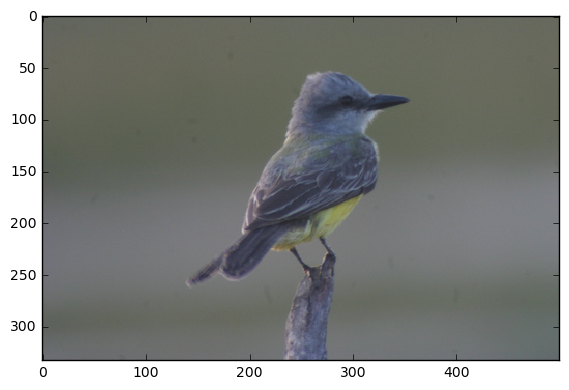

Processing 0100.png...


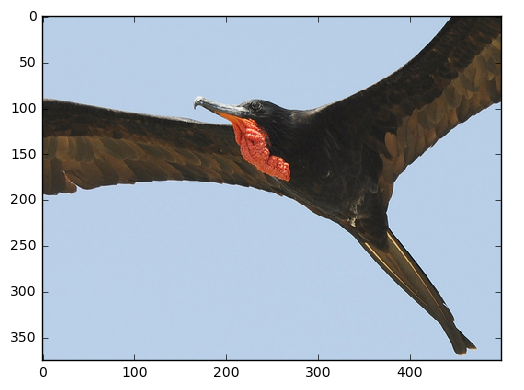

Processing 0200.png...


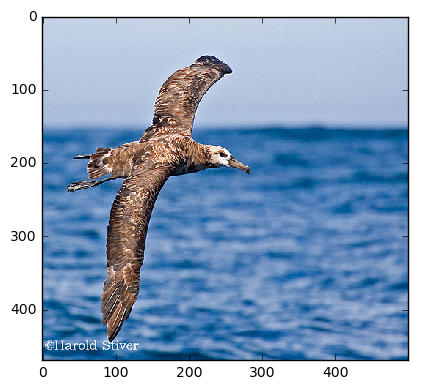

Processing 0300.png...


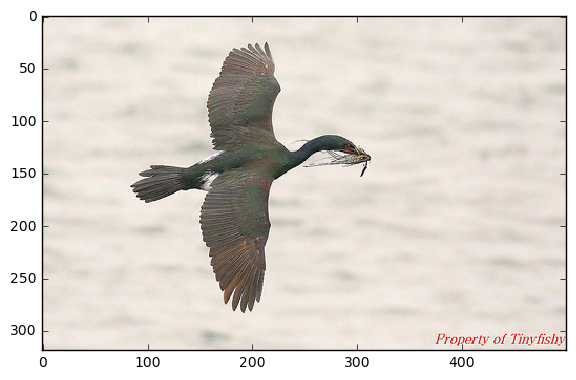

Processing 0400.png...


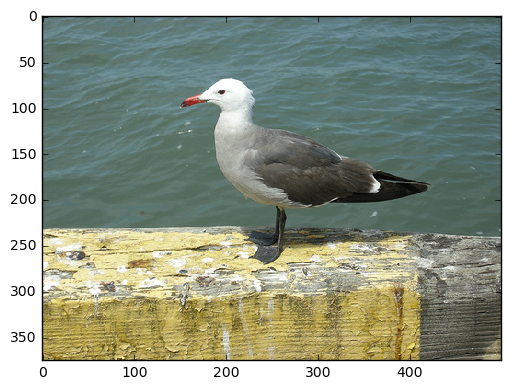

Processing 0500.png...


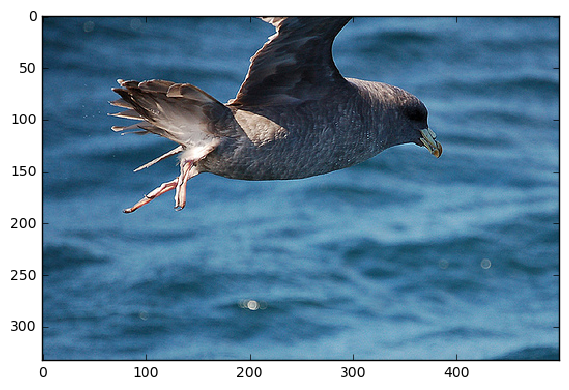

Processing 0600.png...


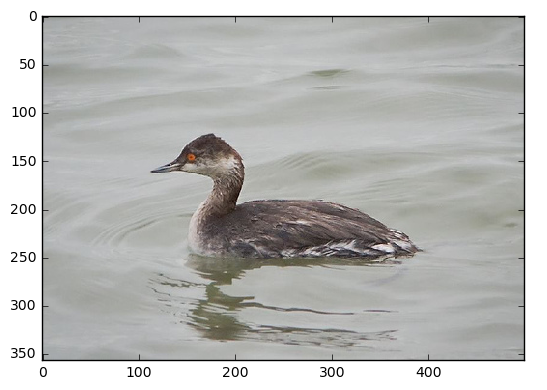

Processing 0700.png...


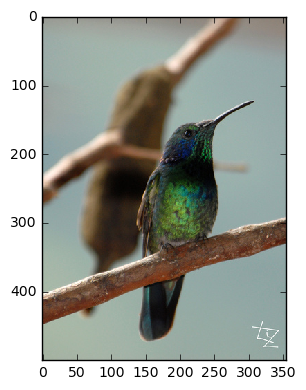

Processing 0800.png...


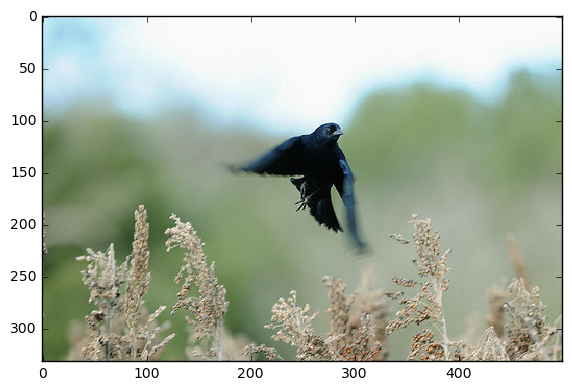

Processing 0900.png...


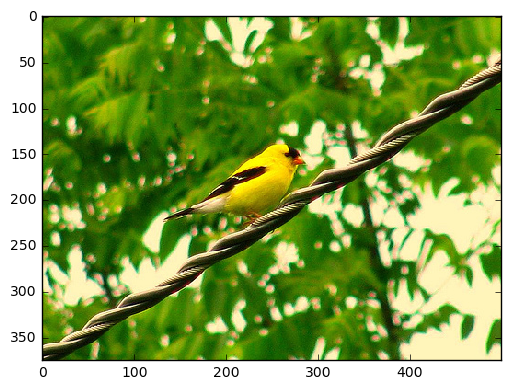

Processing 1000.png...


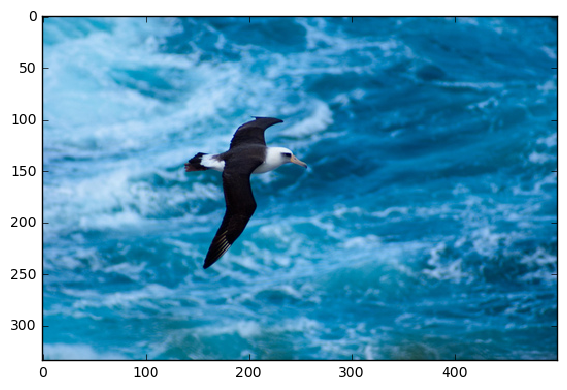

Processing 1100.png...


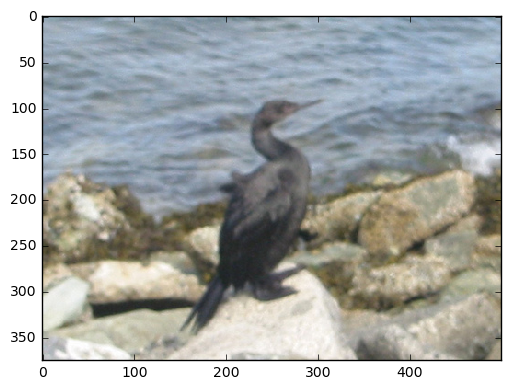

Processing 1200.png...


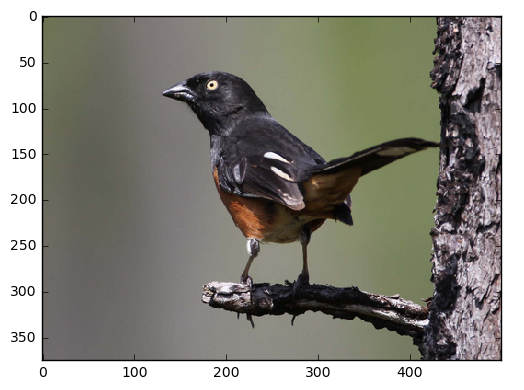

Processing 1300.png...


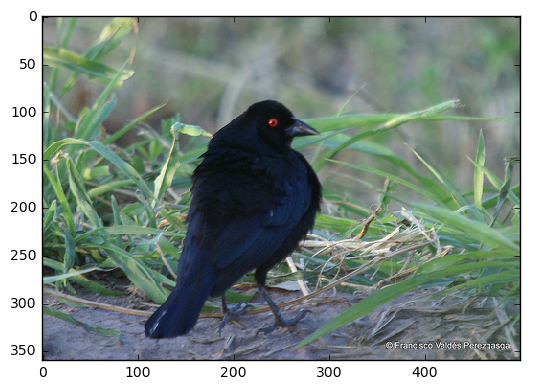

Processing 1400.png...


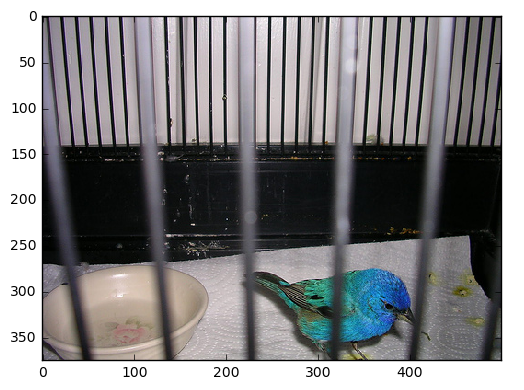

Processing 1500.png...


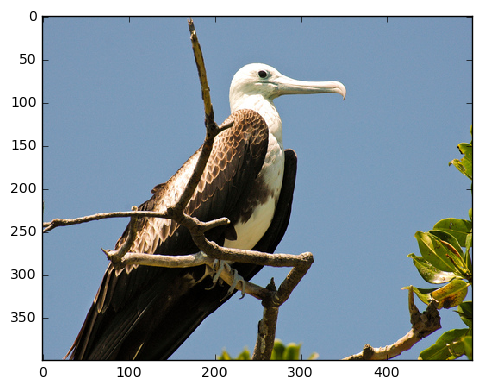

Processing 1600.png...


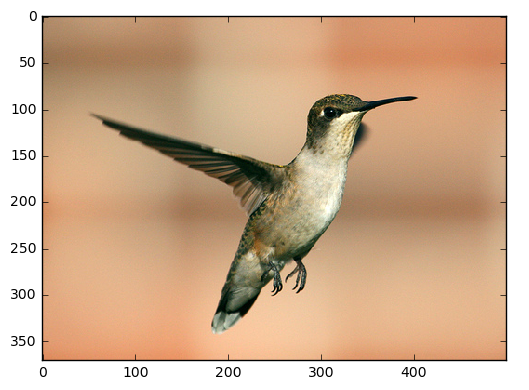

Processing 1700.png...


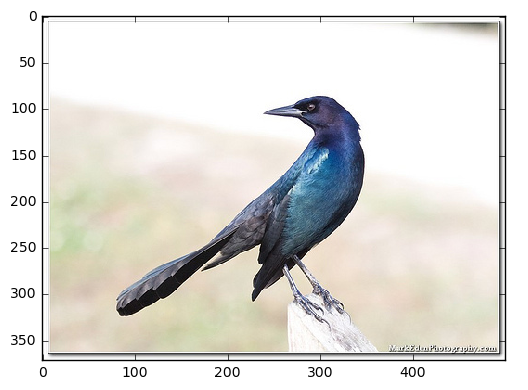

Processing 1800.png...


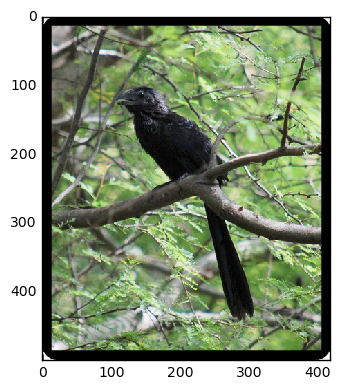

Processing 1900.png...


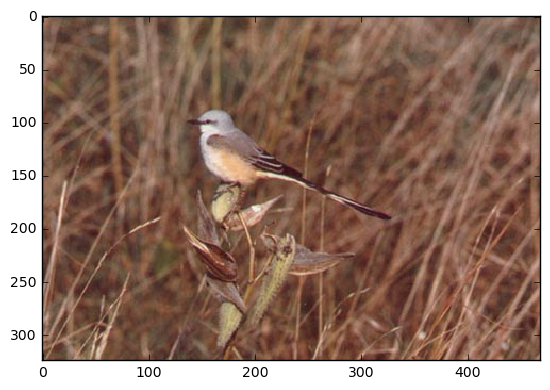

Processing 2000.png...


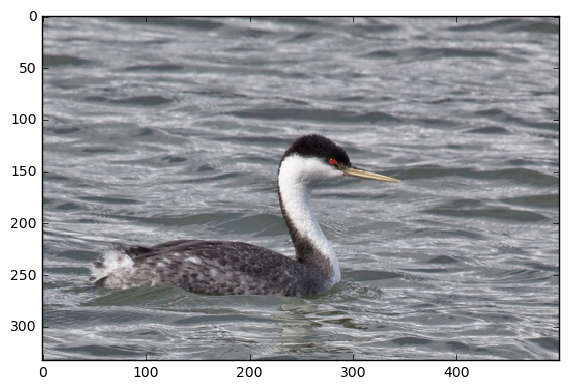

Processing 2100.png...


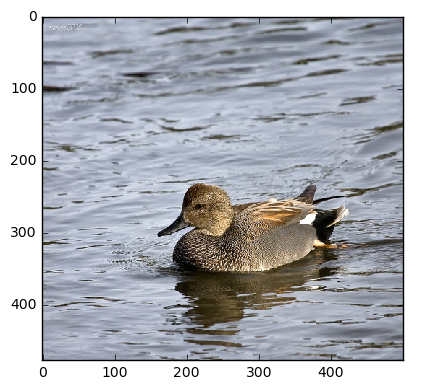

Processing 2200.png...


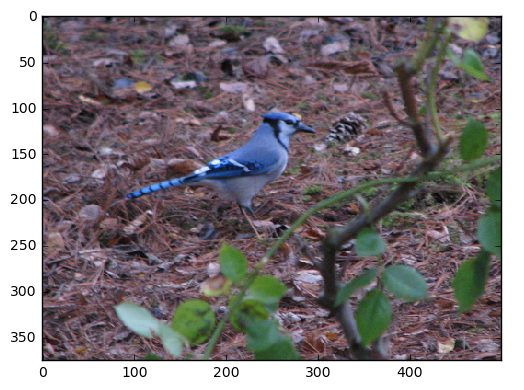

Processing 2300.png...


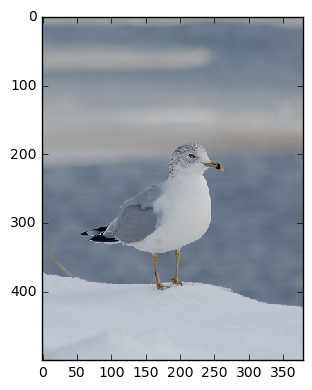

Processing 2400.png...


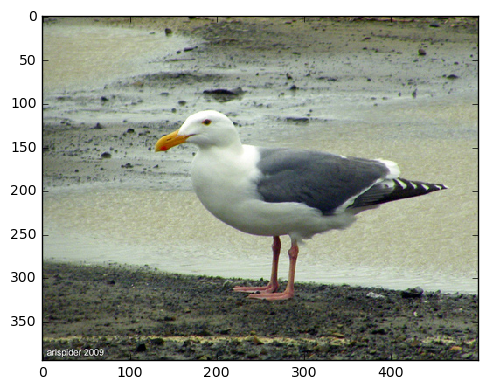

In [8]:
features = extract_features(TRAIN_IMAGES)

### Модель

In [44]:
def Model(features, labels, test_features=None):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, labels,
                                                                         test_size=0.2, random_state=42)
    clf = LinearSVC(penalty='l2', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print("Accuracy: {0:0.1f}%".format(accuracy_score(y_test, y_pred)*100))
    
    y_pred_test = None
    if test_features is not None:
        y_pred_test = clf.predict(test_features)
    return y_pred_test

In [15]:
LogRegression(features, labels)

/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 83.2%


In [20]:
LogRegression(features, labels)

/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Process ForkPoolWorker-4:
Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.4/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/usr/lib/python3.4/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/usr/lib/python3.4/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/usr/lib/python3.4/

KeyboardInterrupt: 

### Загрузка тестовых изображений и расчет нейросетевых признаков

In [21]:
test_images = sorted([os.path.join(TEST_PATH, f) for f in os.listdir(TEST_PATH)])
test_images[:3]

['./finetuning-test/images/0000.png',
 './finetuning-test/images/0001.png',
 './finetuning-test/images/0002.png']

In [22]:
len(test_images)

500

In [24]:
test_features = extract_features(test_images)

Processing 0000.png...
Processing 0100.png...
Processing 0200.png...
Processing 0300.png...
Processing 0400.png...


In [45]:
test_labels = Model(features, labels, test_features)

/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 81.6%


In [46]:
answer = []
for ind, img in enumerate(test_images):
    filename = img.split('/')[-1]
    label = test_labels[ind]
    answer.append([filename, label])

In [47]:
ans_frame = pd.DataFrame(answer)
ans_frame.to_csv('answer.csv', header=['filename', 'class_id'], index=False)